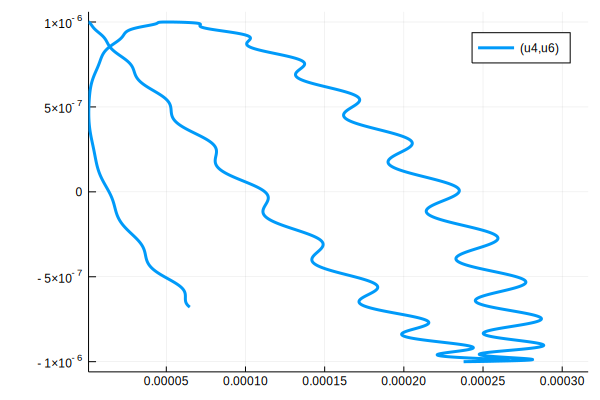

In [2]:
# vykresleni trajektorie iontu
# 27.11.2019

using Plots
include("ion_traj.jl")

# parametry pasti
Vrf = 400  # napeti radialnich elektrod [V]
Udc = 1300  # napeti axialnich elektrod [V]
Ω = 2*pi * 30e6 # budici frekvence pasti [Hz]

# pocatecni podminky
u0 = [0, 0, 0, 1e-6,1e-7,1e-6] # v metrech

# externi DC pole
E_ext = [3000, 0, 0]
tspan = (0.0, 1.0e-6)  # casovy rozsah reseni

traj = get_ion_traj(Vrf, Udc, Ω, E_ext, u0, tspan) # trajektorie iontu

gr()
plot(traj, vars=(4,6))

# Optimalizace ODE řešiče

In [8]:
# konstanty
m = 40 * convert(Float64,AtomicMassConstant / (1u"kg")) # hmotnost iontu
e = convert(Float64, ElementaryCharge / 1u"C") # naboj iontu
z0 = 2.25e-3  # vzdalenost axialnich elektrod od stredu pasti [m]
r0 = 0.6167e-3 # vzdalenost radialnich elektrod od stredu pasti [m]
κ = 0.0597
charge_mass_ratio = e/m

# parametry pasti
Vrf = 400  # napeti radialnich elektrod [V]
Udc = 1300  # napeti axialnich elektrod [V]
Ω = 2*pi * 30e6 # budici frekvence pasti [Hz]

# pocatecni podminky
u0 = [0, 0, 0, 1e-6,1e-7,1e-6] # v metrech

# externi DC pole
E_ext = [0, 0, 0]

# fukce pro ODE solver
function ion_motion!(du, u, p, t)
    # funkce pocita zmeny souradnic u podle pohybove rovnice, je treba 6 rovnic prvniho radu
    # u = [vx, vy, vz, x, y, z]
    Vrf, Udc, Ω, z0, r0, κ, m, e, charge_mass_ratio, E_ext = p # parametry vypoctu

    c_x = (κ*Udc/z0^2 + Vrf/r0^2 * cos(Ω*t) ) # konstanta pro vypocet E_x
    c_y = (κ*Udc/z0^2 - Vrf/r0^2 * cos(Ω*t) ) # konstanta pro vypocet E_y
    c_z = -2*κ*Udc/z0^2 # konstanta pro vypocet E_z

    du[1] = charge_mass_ratio * (c_x*u[4] + E_ext[1]) # dvx
    du[2] = charge_mass_ratio * (c_y*u[5] + E_ext[2]) # dvy
    du[3] = charge_mass_ratio * (c_z*u[6] + E_ext[3]) # dvz

    du[4] = u[1] # dx
    du[5] = u[2] # dy
    du[6] = u[3] # dz
end

# ode solver
p = [Vrf, Udc, Ω, z0, r0, κ, m, e, charge_mass_ratio, E_ext] # parametry ODE

prob = ODEProblem(ion_motion!, u0, tspan, p) # definice problemu pro ODE solver

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 1.0e-6)
u0: [0.0, 0.0, 0.0, 1.0e-6, 1.0e-7, 1.0e-6]

In [53]:
#using BenchmarkTools

traj1 = solve(prob, Vern7(), abstol=1e-8, reltol=1e-6)

traj2 = solve(prob)

traj3 = solve(prob, abstol=1e-9, reltol=1e-9)

  1.486 ms (101642 allocations: 1.93 MiB)


retcode: Success
Interpolation: Automatic order switching interpolation
t: 270-element Array{Float64,1}:
 0.0                  
 4.764065757840322e-9 
 7.700987844517562e-9 
 1.1718552794326064e-8
 1.5102104217148167e-8
 1.8771751505283285e-8
 2.2137637965936173e-8
 2.5747516748776084e-8
 2.944201194479484e-8 
 3.32267234986086e-8  
 3.6569621996531825e-8
 4.001378510896807e-8 
 4.3834553585921523e-8
 ⋮                    
 9.62974893919028e-7  
 9.66790408210954e-7  
 9.702551825306898e-7 
 9.738374274337042e-7 
 9.774639917333432e-7 
 9.80930727372675e-7  
 9.845172267440724e-7 
 9.881322089151912e-7 
 9.917379887325722e-7 
 9.956046181590915e-7 
 9.99402502668714e-7  
 1.0e-6               
u: 270-element Array{Array{Float64,1},1}:
 [0.0, 0.0, 0.0, 1.0e-6, 1.0e-7, 1.0e-6]                                                                                           
 [10.791327546635284, -1.026709672148582, -0.3522412303785172, 1.0274436523013405e-6, 9.736232048827486e-8, 9.9916083242118

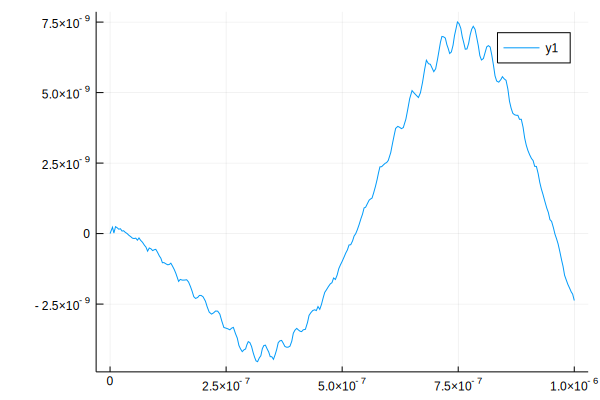

In [52]:
t = traj1.t
traj1_mat = convert(Array, traj1)

traj2_mat = convert(Array, traj2(t))
traj3_mat = convert(Array, traj3(t))

gr()
plot(t, traj2_mat[4,:] - traj3_mat[4,:])